***

# Homework 4

**Course:** MATH 616 - Data-Driven Dynamical Systems, Stochastic Modeling and Prediction

**Name:** Shrivats Sudhir

**NetID:** ssudhir2

**Email:** ssudhir2@wisc.edu

***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit

# Question 1.

**Consider the following linear Gaussian model:**

$$d\;x(t) = [-a \cdot x(t) + f]\;dt + \sigma_{x}\;dW_{x}(t)$$

## (a.)

**Write down a general code for Kalman filter and show the numerical results with $a = f = \sigma_{x} = 1$, the observational time step $\Delta t = 0.4$ and the observational noise level $\sigma_0 = 0.5$.**

**You may consider a time series with the total length $T = 500$.**

In [2]:
# Simulation parameters
x0 = 0.0               # Initial state
a = 1.0                # Drift coefficient
f = 1.0                # Forcing term
sigma_x = 1.0          # Diffusion coefficient
sigma_0 = 0.5          # Observation Noise SD
delta_t = 0.4          # Time step size
T = 500                # Total simulation time
N = int(T / delta_t)   # Number of time steps

The following solution is inspired by 10.1.2 from the lecture notes.

The exact path-wise solution from $t_m$ to $t_{m+1}$ can be expressed explicitly:
\begin{equation*}
    \begin{split}
        x(t_{m+1}) &= \underbrace{x(t_m) \cdot \text{exp}(-a \cdot \Delta t)}_{\text{Deterministic Decay of } x(t_m): A_m x(t_m) }\\
        \\
        & \quad - \underbrace{\frac{f}{a} \cdot (1 - \text{exp}(-a \cdot \Delta t))}_{\text{Forcing Term: } F_m }\\
        \\
        & \quad + \underbrace{\sigma_x \cdot \int_{t_{m+1}}^{t_{m}} \text{exp}(-a \cdot (t_{m+1} - s))\; dW(s)}_{\text{Stochastic Term: } \sigma_m }
    \end{split}
\end{equation*}

For the stochastic term, we can use Monte Carlo Simulations as follows:
$$\int_{t_{m+1}}^{t_{m}} \text{exp}(-a \cdot (t_{m+1} - s))\; dW(s) \approx \sum_{i=1}^{N} \text{exp}(-a \cdot (t_{m+1} - t_i)) \cdot \Delta W_i $$
where $\Delta W_i \sim N(0, \sqrt{ \Delta t / N })$

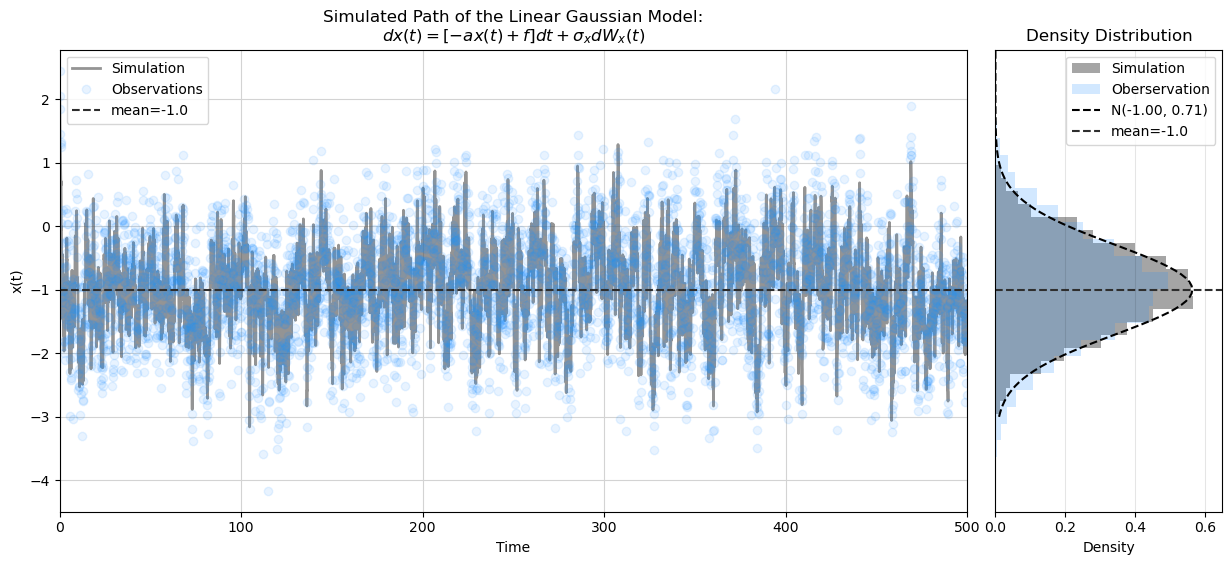

In [18]:
def approximate_stochastic_term(a, delta_t, N):
    """
    Approximates the stochastic integral term in the SDE using Monte Carlo.

    Parameters:
        a (float): Drift coefficient in the SDE.
        delta_t (float): Time step size (t_{m+1} - t_m).
        N (int): Number of sub-intervals for numerical approximation.

    Returns:
        float: Approximation of the stochastic term.
    """
    # Discretize the time interval
    t = np.linspace(0, delta_t, N + 1)  # Subdivision times
    dW = np.random.normal(0, np.sqrt(delta_t / N), size=N)  # Wiener increments

    # Compute the stochastic integral
    stochastic_term = 0
    for i in range(N):
        exp_factor = np.exp(-a * (delta_t - t[i]))  # Exponential decay factor
        stochastic_term += exp_factor * dW[i]       # Accumulate contributions

    return stochastic_term


def simulate_exact_path(x0, a, f, sigma_x, delta_t, T):
    """
    Simulates the exact path of the linear SDE model.

    The SDE is of the form:
        dx(t) = [-a * x(t) + f] * dt + sigma_x * dW(t)

    Parameters:
        x0 (float): Initial state of the system.
        a (float): Drift coefficient in the SDE.
        f (float): Forcing term.
        sigma_x (float): Diffusion coefficient (noise intensity).
        delta_t (float): Time step size.
        T (float): Total simulation time.

    Returns:
        numpy.ndarray: Simulated path of the system over time.
    """
    # Number of time steps
    N = int(T/delta_t)

    # Initialize the solution array
    x = np.zeros(N+1)

    # Set initial condition
    x[0] = x0

    # Simulate over the time grid
    for t in range(N):
        decay = x[t] * np.exp(-a * delta_t)                                     # Deterministic decay
        forcing = -f/a * (1 - np.exp(-a * delta_t))                             # Forcing term
        stochastic = sigma_x * approximate_stochastic_term(a, delta_t, N=100)   # Stochastic term

        # Update the state
        x[t+1] = decay + forcing + stochastic

    return x

# Generate time grid
time = np.linspace(0, T, N + 1)

# Simulate the path
true_path = simulate_exact_path(x0, a, f, sigma_x, delta_t, T)

# Simulated noisy observations
observations = true_path + np.random.normal(0, sigma_0, size=N + 1)

# Create figure with custom layout
fig = plt.figure(figsize=(15, 6))
gs = plt.GridSpec(1, 2, width_ratios=[4, 1], wspace=0.05)

# Left subplot: Time series (larger)
ax1 = plt.subplot(gs[0])
ax1.plot(time, true_path, color="#4D4D4D", label="Simulation", linewidth=2, alpha=0.6)
ax1.plot(time, observations, 'o', label="Observations", color='#1E90FF', alpha=0.1)
ax1.axhline(y=-f/a, color="#2E2E2E", linestyle='--', label=f"mean={-f/a}")
ax1.set_title("Simulated Path of the Linear Gaussian Model:\n$dx(t)=[-ax(t) + f] dt + \\sigma_x dW_x(t)$")
ax1.set_xlabel("Time")
ax1.set_ylabel("x(t)")
ax1.legend()
ax1.set_xlim(0.0, 500)
ax1.grid(color="#D3D3D3")

# Right subplot: Rotated histogram
ax2 = plt.subplot(gs[1])
ax2.hist(true_path, bins=25, density=True, orientation='horizontal',
         alpha=0.5, color='#4D4D4D', label='Simulation')
ax2.hist(observations, bins=25, density=True, orientation='horizontal',
         alpha=0.2, color='#1E90FF', label='Oberservation')

y = np.linspace(-3, 3, 100)
pdf1 = norm.pdf(y, -f/a, np.sqrt( sigma_x**2/(2*a) ))
ax2.plot(pdf1, y, color="black", 
         linestyle='--', label=f'N({-f/a:.2f}, {np.sqrt( sigma_x**2/(2*a) ):.2f})')
ax2.axhline(y=-f/a, color="#2E2E2E", linestyle='--', label=f"mean={-f/a}")
ax2.set_title('Density Distribution')
ax2.set_xlabel('Density')
ax2.set_ylabel('')
ax2.set_facecolor('white')
ax2.grid(True, color='black', alpha=0.1)
ax2.legend()

ylim = ax1.get_ylim()
ax2.set_ylim(ylim)
ax2.set_xlim(0.0, 0.65)
ax2.set_yticks([])

plt.show()

Now, by 10.1.1, we know that the prior distribution is:
\begin{equation*}
    \begin{split}
        \bar{x}_{m+1|m} &= A_m \bar{x}_{m|m} + F_m\\
                        &= \bar{x}(t_m) \cdot \text{exp}(-a \cdot \Delta t)\\
                        & \quad + f/a \cdot (1 - \text{exp}(-a \cdot \Delta t))
    \end{split}
\end{equation*}

\begin{equation*}
    \begin{split}
        r_{m+1|m} &= A^2_m r_{m|m} + r\\
                  &= \text{exp}(-2a \cdot \Delta t) r_{m|m} + r
    \end{split}
\end{equation*}

In [4]:
def prior_parameters(prior_x, prior_r, f, a, delta_t, r):
    """
    Computes the prior mean and variance based on the given equations.

    Parameters:
        x_prior (float): The posterior mean from the previous step (x_{m|m}).
        r_prior (float): The posterior variance from the previous step (r_{m|m}).
        a (float): Drift coefficient in the SDE.
        f (float): Forcing term.
        delta_t (float): Observational time step size.
        r(float): Process noise variance (sigma_x^2).
    
    Returns:
        tuple: (updated_mean, updated_variance)
    """
    A_m = np.exp(-a * delta_t)
    F_m = f/a * (1 - np.exp(-a * delta_t))

    return A_m * prior_x + F_m, A_m**2 * prior_r + r

# Input parameters
x_prior = 0.0           # Initial posterior mean
r_prior = 0.0           # Initial posterior variance
a = 1.0                 # Drift coefficient
f = 1.0                 # Forcing term
delta_t = 0.4           # Observational time step size
sigma_x = 1.0           # Process noise standard deviation
r_process = sigma_x**2  # Process noise variance

# Compute prior mean and variance
prior_mean, prior_r = prior_parameters(x_prior, r_prior, a, f, delta_t, r_process)
print("prior mean:", prior_mean)
print("prior variance:", prior_r)

prior mean: 0.3296799539643608
prior variance: 1.0


The Kalman gain is:
$$K_{m+1} = \frac{r_{m+1|m}}{r^0 + r_{m+1|m}}$$

The posterior mean and variance can be computed as:
\begin{equation*}
    \begin{split}
        \bar{x}_{m+1|m+1} &= (1 - K_{m+1}) \cdot \bar{x}_{m+1|m} + v_{m+1} \cdot K_{m+1}
    \end{split}
\end{equation*}

\begin{equation*}
    \begin{split}
        r_{m+1|m} &= (1 - K_{m+1}) \cdot r_{m+1 | m}
    \end{split}
\end{equation*}

In [5]:
def kalman_update(prior_mean, prior_r, v_obs, r_obs):
    """
    Computes the posterior mean and variance using the Kalman filter equations.
    
    Parameters:
        mean_prior (float): Prior mean (x_{m+1|m}).
        r_prior (float): Prior variance (r_{m+1|m}).
        z_obs (float): Observed value (z_{m+1}).
        r_obs (float): Observation noise variance (r^0).
    
    Returns:
        tuple: (posterior_mean, posterior_variance, kalman_gain)
    """

    # Computing Kalman Gain
    kalman_update = prior_r / (prior_r + r_obs) if (r_prior + r_obs) != 0 else 0

    # Update posterior mean
    posterior_mean = prior_mean + kalman_update * (v_obs - prior_mean)

    # Update posterior variance
    posterior_variance = (1 - kalman_update) * prior_r

    return (posterior_mean, posterior_variance, kalman_update)

# Example usage
v_obs = 1.0              # Example observation
r_obs = sigma_x**2       # Observation noise variance

(posterior_mean, posterior_variance, kalman_g) = kalman_update(prior_mean, prior_r, v_obs, r_obs)
print("Kalman Gain:", kalman_g)
print("Posterior Mean:", posterior_mean)
print("Posterior Variance:", posterior_variance)

Kalman Gain: 0.5
Posterior Mean: 0.6648399769821804
Posterior Variance: 0.5


Finally, putting it all together, we have:

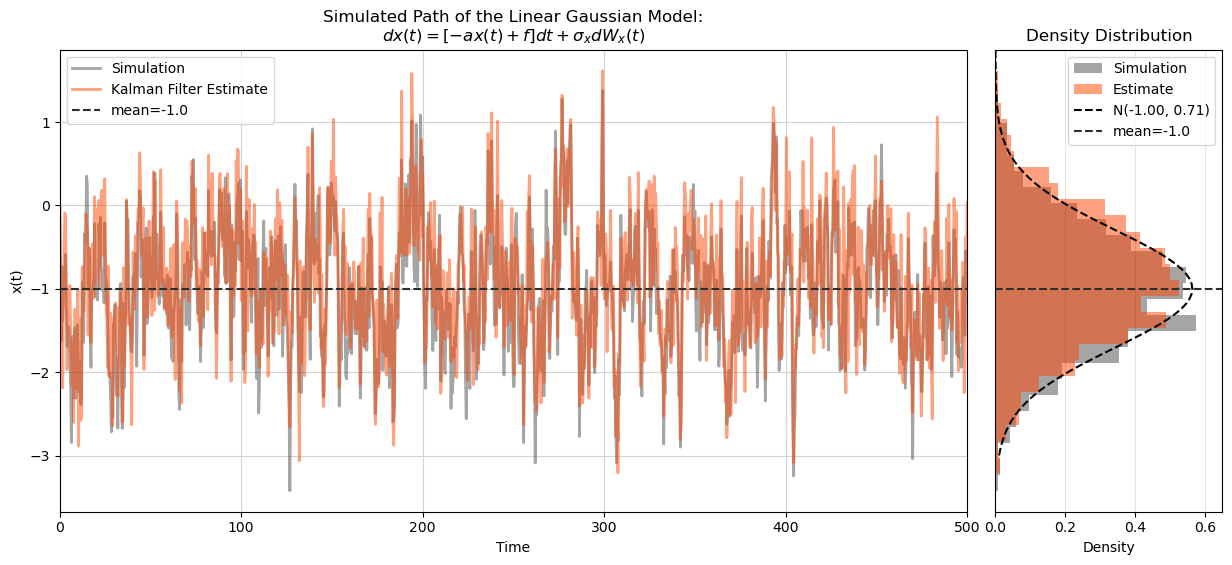

In [6]:
# Complete the Kalman filter loop implementation
kalman_means = np.zeros(N+1)      # Store Kalman filter means
kalman_variance = np.zeros(N+1)   # Store Kalman filter variances

# Initialize with prior values
kalman_means[0] = 0.0     # Initial mean
kalman_variance[0] = 1.0  # Initial variance

for t in range(1, N+1):

    # Compute prior parameters
    prior_mean, prior_r = prior_parameters(
        kalman_means[t - 1], kalman_variance[t - 1],
        a, f, delta_t, sigma_x**2
    )

    # Update with observation
    posterior_mean, posterior_variance, kalman_gain = kalman_update(
        prior_mean, prior_r, observations[t], sigma_0**2
    )

    # Store updated values
    kalman_means[t] = posterior_mean
    kalman_variance[t] = posterior_variance

# Generate time grid
time = np.linspace(0, T, N + 1)

# Plot results with custom layout
fig = plt.figure(figsize=(15, 6))
gs = plt.GridSpec(1, 2, width_ratios=[4, 1], wspace=0.05)

# Left subplot: Time series (larger)
ax1 = plt.subplot(gs[0])
ax1.plot(time, true_path, color="#4D4D4D", label="Simulation", linewidth=2, alpha=0.5)
ax1.plot(time, kalman_means, color="#FF4500", label="Kalman Filter Estimate", linewidth=2, alpha=0.5)
ax1.axhline(y=-f/a, color="#2E2E2E", linestyle='--', label=f"mean={-f/a}")
ax1.set_title("Simulated Path of the Linear Gaussian Model:\n$dx(t)=[-ax(t) + f] dt + \\sigma_x dW_x(t)$")
ax1.set_xlabel("Time")
ax1.set_ylabel("x(t)")
ax1.legend()
ax1.set_xlim(0.0, 500)
ax1.grid(color="#D3D3D3")

# Right subplot: Rotated histogram
ax2 = plt.subplot(gs[1])
ax2.hist(true_path, bins=25, density=True, orientation='horizontal',
         alpha=0.5, color='#4D4D4D', label='Simulation')
ax2.hist(kalman_means, bins=25, density=True, orientation='horizontal',
         alpha=0.5, color='#FF4500', label='Estimate')

y = np.linspace(-3, 3, 100)
pdf1 = norm.pdf(y, -f/a, np.sqrt( sigma_x**2/(2*a) ))
ax2.plot(pdf1, y, color="black", 
         linestyle='--', label=f'N({-f/a:.2f}, {np.sqrt( sigma_x**2/(2*a) ):.2f})')
ax2.axhline(y=-f/a, color="#2E2E2E", linestyle='--', label=f"mean={-f/a}")
ax2.set_title('Density Distribution')
ax2.set_xlabel('Density')
ax2.set_ylabel('')
ax2.set_facecolor('white')
ax2.grid(True, color='black', alpha=0.1)
ax2.legend()

ylim = ax1.get_ylim()
ax2.set_ylim(ylim)
ax2.set_xlim(0.0, 0.65)
ax2.set_yticks([])

plt.show()

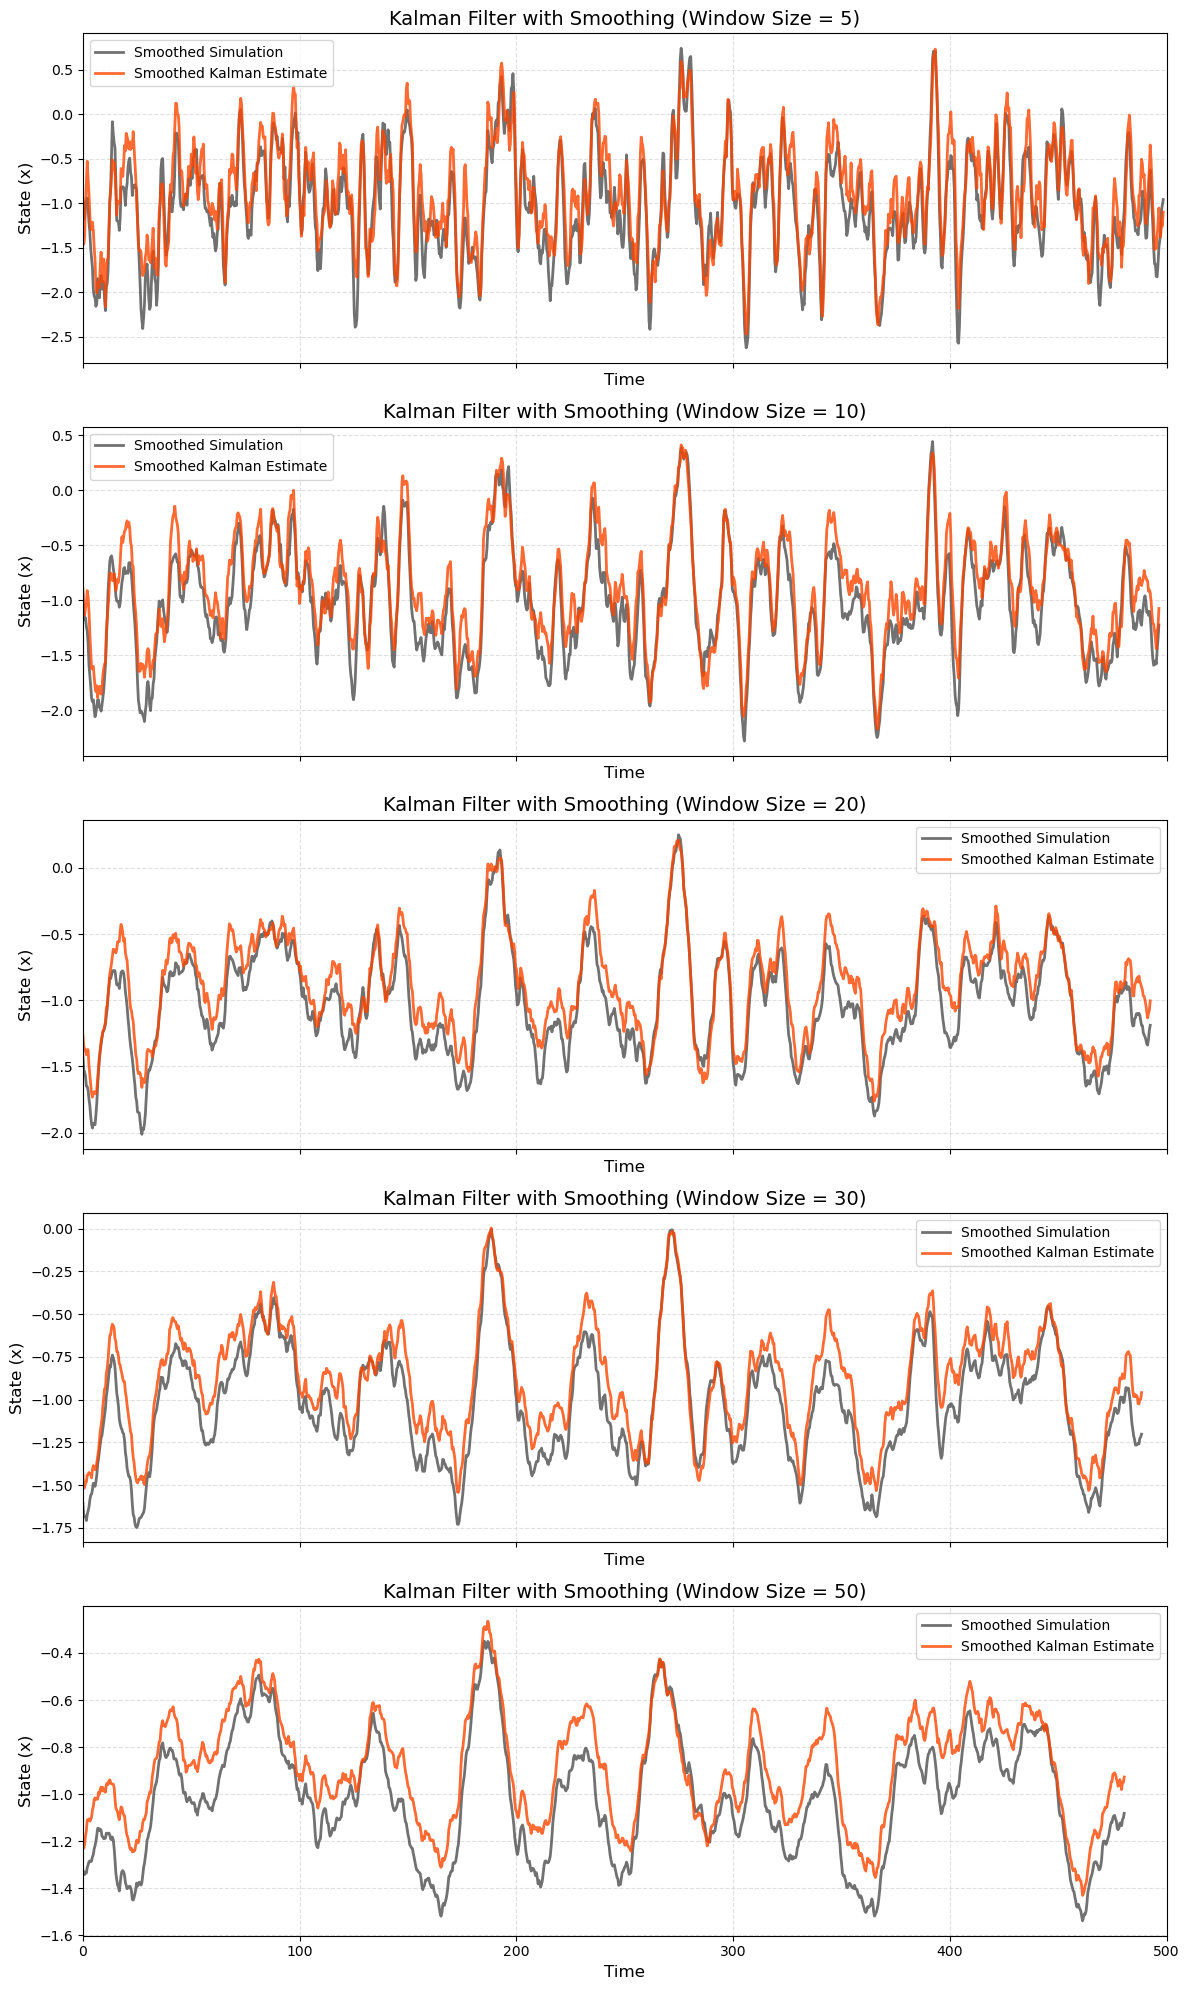

In [7]:
# Function to apply a moving average for smoothing
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Define smoothing window sizes for each subplot
window_sizes = [5, 10, 20, 30, 50]

# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 20), sharex=True)
fig.subplots_adjust(hspace=0.5)

for i, window_size in enumerate(window_sizes):
    # Apply smoothing
    smoothed_true_path = moving_average(true_path, window_size)
    smoothed_kalman_means = moving_average(kalman_means, window_size)
    smoothed_time = time[:len(smoothed_true_path)]

    # Plot smoothed results
    ax = axes[i]
    ax.plot(smoothed_time, smoothed_true_path, color="#4D4D4D", label="Smoothed Simulation", linewidth=2, alpha=0.8)
    ax.plot(smoothed_time, smoothed_kalman_means, color="#FF4500", label="Smoothed Kalman Estimate", linewidth=2, alpha=0.8)
    ax.set_title(f"Kalman Filter with Smoothing (Window Size = {window_size})", fontsize=14)
    ax.set_xlabel("Time", fontsize=12)
    ax.set_ylabel("State (x)", fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(color="#D3D3D3", linestyle="--", alpha=0.7)
    ax.set_xlim(0.0, 500)

plt.tight_layout()
plt.show()

## (b.)

**Show the root-mean-square error (RMSE) in the posterior mean as a function of $\sigma_0$ (keep other parameters the same as above). You may consider a time series with the total length $T=500$ and compute the RMSE from the period from $t=50$ to $500$.**

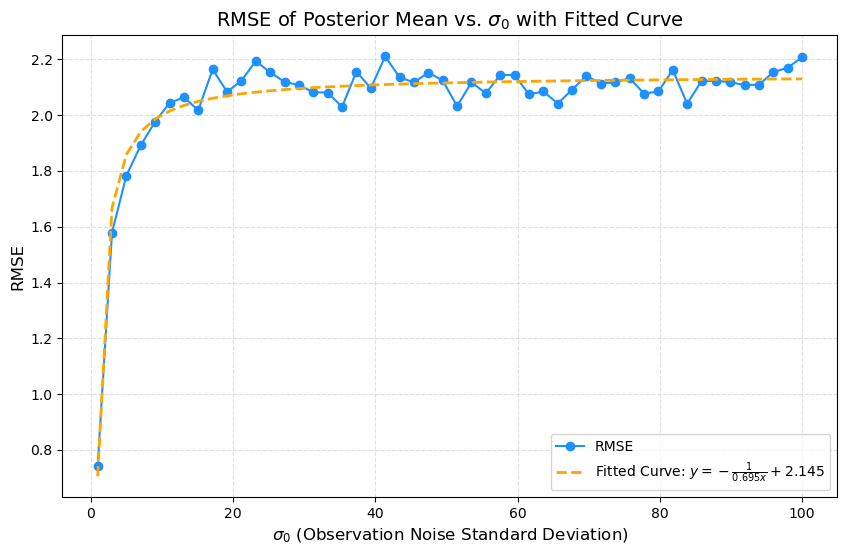

In [8]:
# Function to compute RMSE of the posterior mean for a given sigma_0
def compute_rmse(sigma_0, M):
    """
    Compute RMSE of the posterior mean for a given observation noise (sigma_0).
    
    Parameters:
        sigma_0 (float): Standard deviation of observation noise.
        M (int): Index from which to start calculating RMSE.
        
    Returns:
        float: Root-mean-square error of the posterior mean.
    """
    # Recalculate N for consistency
    N = int(T / delta_t)
    
    # Simulate the true path
    true_path = simulate_exact_path(x0, a, f, sigma_x, delta_t, T)

    # Simulated noisy observations
    observations = true_path + np.random.normal(0, sigma_0, size=N + 1)

    # Initialize Kalman filter variables
    kalman_means = np.zeros(N + 1)
    kalman_variances = np.zeros(N + 1)

    kalman_means[0] = 0.0       # Initial posterior mean
    kalman_variances[0] = 1.0   # Initial posterior variance

    for t in range(1, N+1):
        # Compute prior parameters
        prior_mean, prior_r = prior_parameters(
            kalman_means[t-1], kalman_variances[t-1],
            a, f, delta_t, sigma_x**2
        )

        # Update with observation
        posterior_mean, posterior_variance, kalman_gain = kalman_update(
            prior_mean, prior_r, observations[t], sigma_0**2
        )

        # Store updated values
        kalman_means[t] = posterior_mean
        kalman_variances[t] = posterior_variance

    # Compute RMSE for the period from M onward
    return np.sqrt(np.mean((true_path[M:] - kalman_means[M:])**2))

# Define the function to fit
def fit_function(x, a, c):
    return -1 / (a * x) + c

# Extended range of sigma_0 values to test
sigma_obs_values = np.linspace(1, 100, 50)

# Compute RMSE values for each sigma_0
rmse_values = [compute_rmse(sigma_obs, M=125) for sigma_obs in sigma_obs_values]

# Fit the data using the defined function
popt, pcov = curve_fit(fit_function, sigma_obs_values, rmse_values, p0=[1, 1])

# Extract fitted parameters
a_fit, c_fit = popt

# Generate the fitted curve
fitted_curve = fit_function(sigma_obs_values, a_fit, c_fit)

# Plot RMSE as a function of sigma_0 with fitted curve
plt.figure(figsize=(10, 6))
plt.plot(sigma_obs_values, rmse_values, marker='o', color="#1E90FF", label="RMSE")
plt.plot(sigma_obs_values, fitted_curve, color="orange", linestyle="--", linewidth=2, 
         label=f"Fitted Curve: $y = -\\frac{{1}}{{{a_fit:.3f}x}} + {c_fit:.3f}$")
plt.title("RMSE of Posterior Mean vs. $\\sigma_0$ with Fitted Curve", fontsize=14)
plt.xlabel("$\\sigma_0$ (Observation Noise Standard Deviation)", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.grid(color="#D3D3D3", linestyle="--", alpha=0.7)
plt.legend(fontsize=10)
plt.show()

# Question 2.

**Consider again the following linear Gaussian model:**
$$d\;x_t = (-ax_t + f)\;dt + \sigma \; dW_t$$
**Choose the parameters to be $a = 0.5$, $f = 1$ and $\sigma = 0.4$. The initial condition is $x(0) = 2$.**

**Since, in data-driven scenarios, we usually do not know the true parameter values, let us assume the following ansatz:**
$$d\;x_t = (-ax_t + bx^2_t + cx^3_t + dx^4_t + ex^5_t + f)\;dt + \sigma \; dW_t$$
**Consider two cases with the total length of the observational time series being $T=5$ and $T=50$. Estimate the parameters using regression and see how the parameter values  change.**

Assuming that the linear Gaussian model:
$$ d\;x_t = (-a x_t + f)\;dt + \sigma\;dW_t $$
is the true state model, we can simulate the data and visualization as follows:

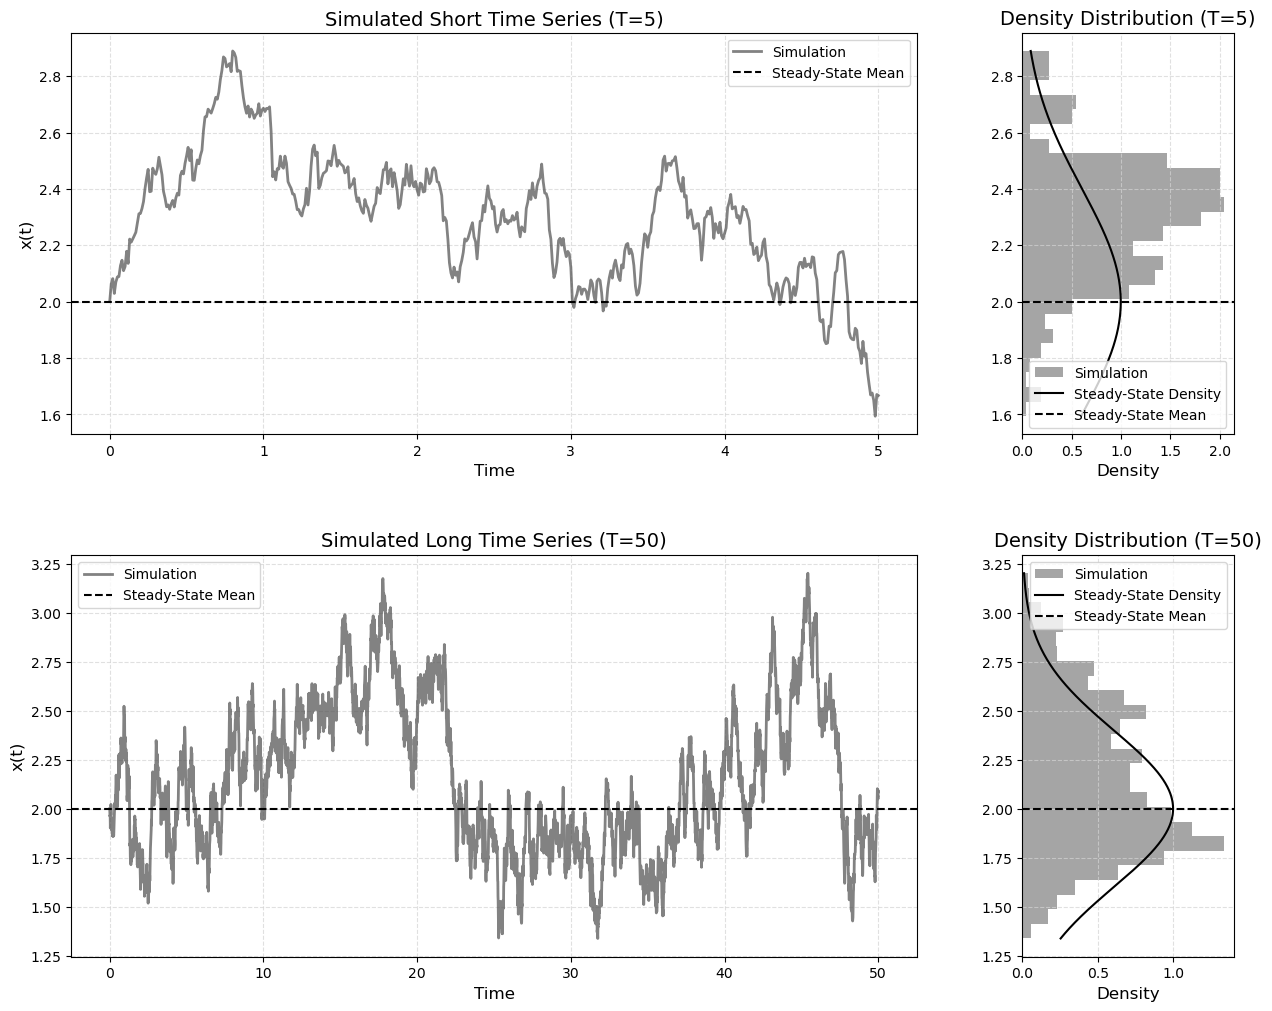

In [9]:
# Euler-Maruyama method specifically for the given drift function
def euler_maruyama_drift(T, N, X0, a, f, sigma):
    dt = T / N
    t = np.linspace(0, T, N + 1)
    Xt = np.zeros(N + 1)
    Xt[0] = X0  # Initial condition

    for i in range(1, N + 1):
        dWt = np.sqrt(dt) * np.random.normal(0, 1)  # Wiener process increment
        Xt[i] = Xt[i-1] + (-a * Xt[i-1] + f) * dt + sigma * dWt  # Euler-Maruyama update

    return t, Xt

# Simulation parameters
a_true = 0.5
f_true = 1
sigma_true = 0.4
x0 = 2

T_short = 5
T_long = 50
N_short = 500
N_long = 5000

# Simulate paths using Euler-Maruyama
time_short, true_short = euler_maruyama_drift(T_short, N_short, x0, a_true, f_true, sigma_true)
time_long, true_long = euler_maruyama_drift(T_long, N_long, x0, a_true, f_true, sigma_true)

# Calculate steady-state parameters
steady_mean = f_true / a_true
steady_std = np.sqrt(sigma_true**2 / (2 * a_true))

# Create figure with custom layout
fig = plt.figure(figsize=(15, 12))
gs = plt.GridSpec(2, 2, width_ratios=[4, 1], hspace=0.3)

# Plot for short time series
ax1 = plt.subplot(gs[0, 0])
ax1.plot(time_short, true_short, 
         color="#4D4D4D", label="Simulation", linewidth=2, alpha=0.7)
ax1.axhline(steady_mean, color="black", linestyle="--", label="Steady-State Mean")
ax1.set_title("Simulated Short Time Series (T=5)", fontsize=14)
ax1.set_xlabel("Time", fontsize=12)
ax1.set_ylabel("x(t)", fontsize=12)
ax1.legend()
ax1.grid(color="#D3D3D3", linestyle="--", alpha=0.7)

# Density for short time series
ax2 = plt.subplot(gs[0, 1])
ax2.hist(true_short, bins=25, density=True, 
         orientation='horizontal', alpha=0.5, color='#4D4D4D', label='Simulation')
y = np.linspace(min(true_short), max(true_short), 500)
ax2.plot(norm.pdf(y, steady_mean, steady_std), y, label="Steady-State Density", color="black")
ax2.axhline(steady_mean, color="black", linestyle="--", label="Steady-State Mean")
ax2.set_title("Density Distribution (T=5)", fontsize=14)
ax2.set_xlabel("Density", fontsize=12)
ax2.set_ylabel("")
ax2.legend()
ax2.grid(color="#D3D3D3", linestyle="--", alpha=0.7)

# Plot for long time series
ax3 = plt.subplot(gs[1, 0])
ax3.plot(time_long, true_long, color="#4D4D4D", 
         label="Simulation", linewidth=2, alpha=0.7)
ax3.axhline(steady_mean, color="black", linestyle="--", label="Steady-State Mean")
ax3.set_title("Simulated Long Time Series (T=50)", fontsize=14)
ax3.set_xlabel("Time", fontsize=12)
ax3.set_ylabel("x(t)", fontsize=12)
ax3.legend()
ax3.grid(color="#D3D3D3", linestyle="--", alpha=0.7)

# Density for long time series
ax4 = plt.subplot(gs[1, 1])
ax4.hist(true_long, bins=25, density=True, 
         orientation='horizontal', alpha=0.5, color='#4D4D4D', label='Simulation')
y = np.linspace(min(true_long), max(true_long), 500)
ax4.plot(norm.pdf(y, steady_mean, steady_std), y, label="Steady-State Density", color="black")
ax4.axhline(steady_mean, color="black", linestyle="--", label="Steady-State Mean")
ax4.set_title("Density Distribution (T=50)", fontsize=14)
ax4.set_xlabel("Density", fontsize=12)
ax4.set_ylabel("")
ax4.legend()
ax4.grid(color="#D3D3D3", linestyle="--", alpha=0.7)

plt.show()

Now, we can approximate $\frac{dx_t}{dt}$ using:
$$ \frac{dx_t}{dt} \approx \frac{x_{t + \Delta t} - x_t}{\Delta t} $$
and visualize them as follows:

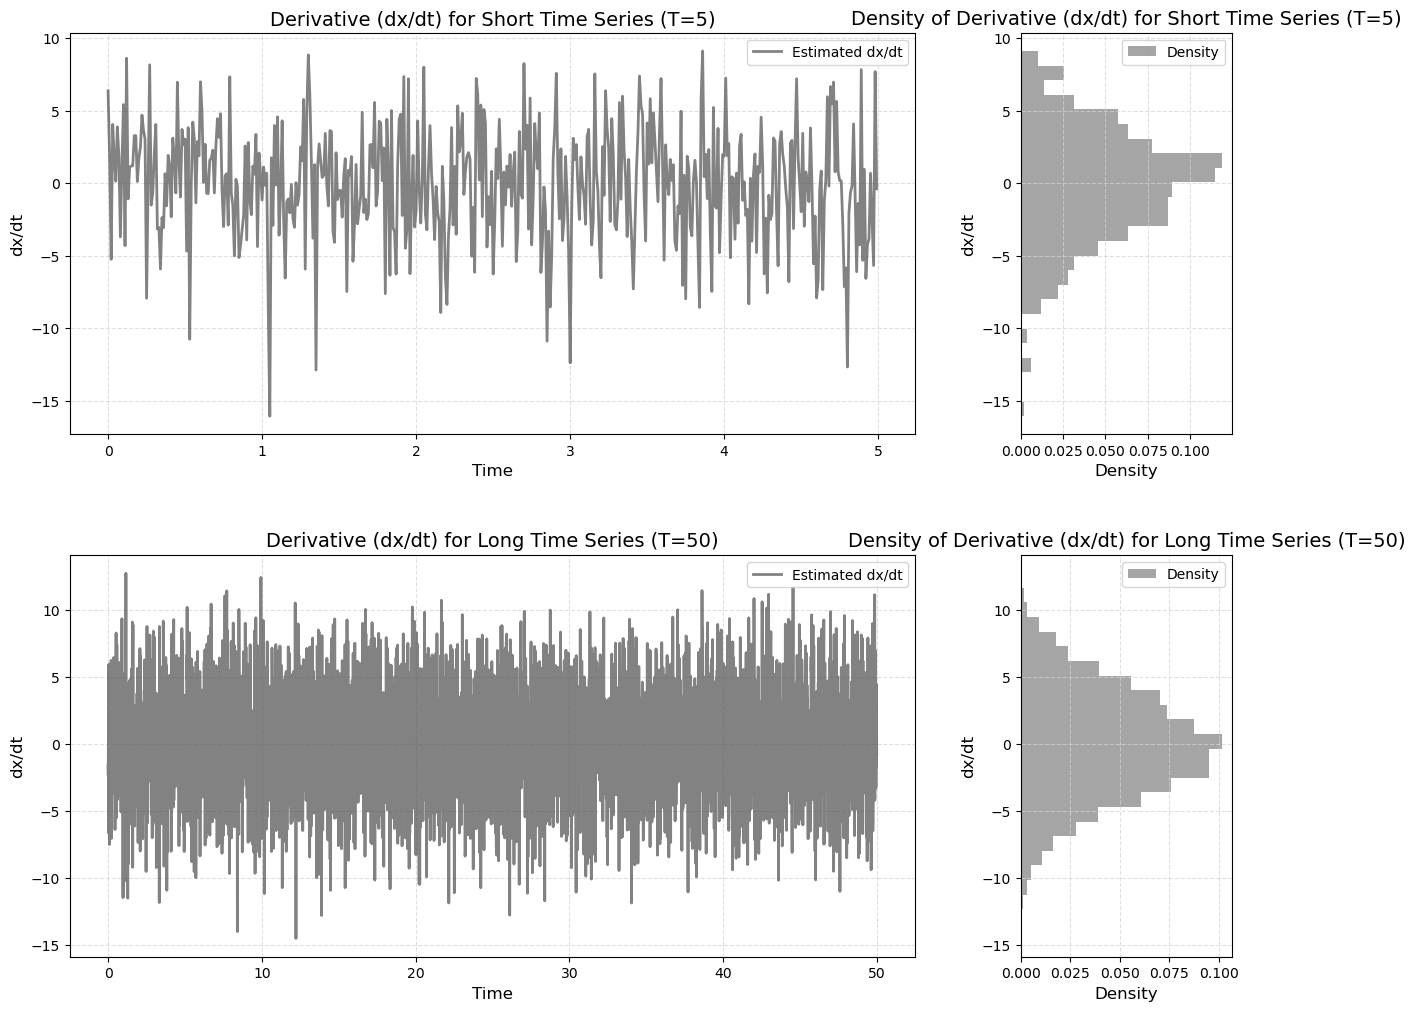

In [10]:
# Define the derivative estimation function
def estimate_dx_dt(x, delta_t):
    return (x[1:] - x[:-1]) / delta_t

# Estimate derivatives for short and long time series
delta_t_short = T_short / N_short
delta_t_long = T_long / N_long

true_short_dxdt = estimate_dx_dt(true_short, delta_t_short)
true_long_dxdt = estimate_dx_dt(true_long, delta_t_long)

# Create plots for dx/dt (derivative)
fig = plt.figure(figsize=(15, 12))
gs = plt.GridSpec(2, 2, width_ratios=[4, 1], hspace=0.3)

# Plot for short time series dx/dt
ax1 = plt.subplot(gs[0, 0])
ax1.plot(time_short[:-1], true_short_dxdt, 
         color="#4D4D4D", label="Estimated dx/dt", linewidth=2, alpha=0.7)
ax1.set_title("Derivative (dx/dt) for Short Time Series (T=5)", fontsize=14)
ax1.set_xlabel("Time", fontsize=12)
ax1.set_ylabel("dx/dt", fontsize=12)
ax1.legend()
ax1.grid(color="#D3D3D3", linestyle="--", alpha=0.7)

# Density for short time series dx/dt
ax2 = plt.subplot(gs[0, 1])
ax2.hist(true_short_dxdt, bins=25, density=True, 
         orientation='horizontal', alpha=0.5, color='#4D4D4D', label='Density')
ax2.set_title("Density of Derivative (dx/dt) for Short Time Series (T=5)", fontsize=14)
ax2.set_xlabel("Density", fontsize=12)
ax2.set_ylabel("dx/dt", fontsize=12)
ax2.legend()
ax2.grid(color="#D3D3D3", linestyle="--", alpha=0.7)

# Plot for long time series dx/dt
ax3 = plt.subplot(gs[1, 0])
ax3.plot(time_long[:-1], true_long_dxdt, color="#4D4D4D", 
         label="Estimated dx/dt", linewidth=2, alpha=0.7)
ax3.set_title("Derivative (dx/dt) for Long Time Series (T=50)", fontsize=14)
ax3.set_xlabel("Time", fontsize=12)
ax3.set_ylabel("dx/dt", fontsize=12)
ax3.legend()
ax3.grid(color="#D3D3D3", linestyle="--", alpha=0.7)

# Density for long time series dx/dt
ax4 = plt.subplot(gs[1, 1])
ax4.hist(true_long_dxdt, bins=25, density=True, 
         orientation='horizontal', alpha=0.5, color='#4D4D4D', label='Density')
ax4.set_title("Density of Derivative (dx/dt) for Long Time Series (T=50)", fontsize=14)
ax4.set_xlabel("Density", fontsize=12)
ax4.set_ylabel("dx/dt", fontsize=12)
ax4.legend()
ax4.grid(color="#D3D3D3", linestyle="--", alpha=0.7)

plt.show()

Now, given the ansatz model, at each time-step $t$, we can compute:
$$ x_t, x^2_t, x^3_t, x^4_t, x^5_t $$
which then, gives us our design matrix $X$ as follows:
$$X = \begin{bmatrix} 
    x_1 & x_1^2 & x_1^3 & x_1^4 & x_1^5 & 1\\
    x_2 & x_2^2 & x_2^3 & x_2^4 & x_2^5 & 1\\
    \vdots & \vdots & \vdots & \vdots & \vdots & \vdots\\
    x_N & x_N^2 & x_N^3 & x_N^4 & x_N^5 & 1\\
\end{bmatrix}, \quad \beta = \begin{bmatrix} -a & b & c & d & e & f \end{bmatrix}^T$$

with the response vector:
$$Y = \begin{bmatrix} \frac{dx_1}{dt} & \dots & \frac{dx_N}{dt} \end{bmatrix}^T$$

Then, we know that:
$$ \min_{\beta} || Y - X\beta || = (X^TX)^{-1}X^TY$$

In [11]:
def design_matrix(x):
    return np.column_stack([x, x**2, x**3, x**4, x**5, np.ones_like(x)])

def minimize_ols(X, Y):
    return np.matmul(
                np.matmul(
                    np.linalg.inv(
                        np.matmul(X.T, X)), X.T), Y)

beta_short = minimize_ols(design_matrix(true_short[:-1]), true_short_dxdt)
beta_long = minimize_ols(design_matrix(true_long[:-1]), true_long_dxdt)
print("Beta for T=5:\n", beta_short, "\n")
print("Beta for T=50:\n", beta_long)

Beta for T=5:
 [-8723.29027766  7778.29140461 -3433.30097594   750.55638168
   -65.04878344  3872.56856122] 

Beta for T=50:
 [ 185.15187935 -183.42003285   86.59668421  -19.66880827    1.72775311
  -70.05868833]


We can see that, from `T=5` to `T=50`, there is vast decrease in estimates $a,b,c,d,e,$ and $f$. That said, we would expect $a \approx 0.5$, $b,c,d,e \approx 0$, and $f \approx 1$. To view long-term behavior, we fit various beta estimates for $N \in \{5,6,\dots,5000\}$ and check the behavior of convergence.

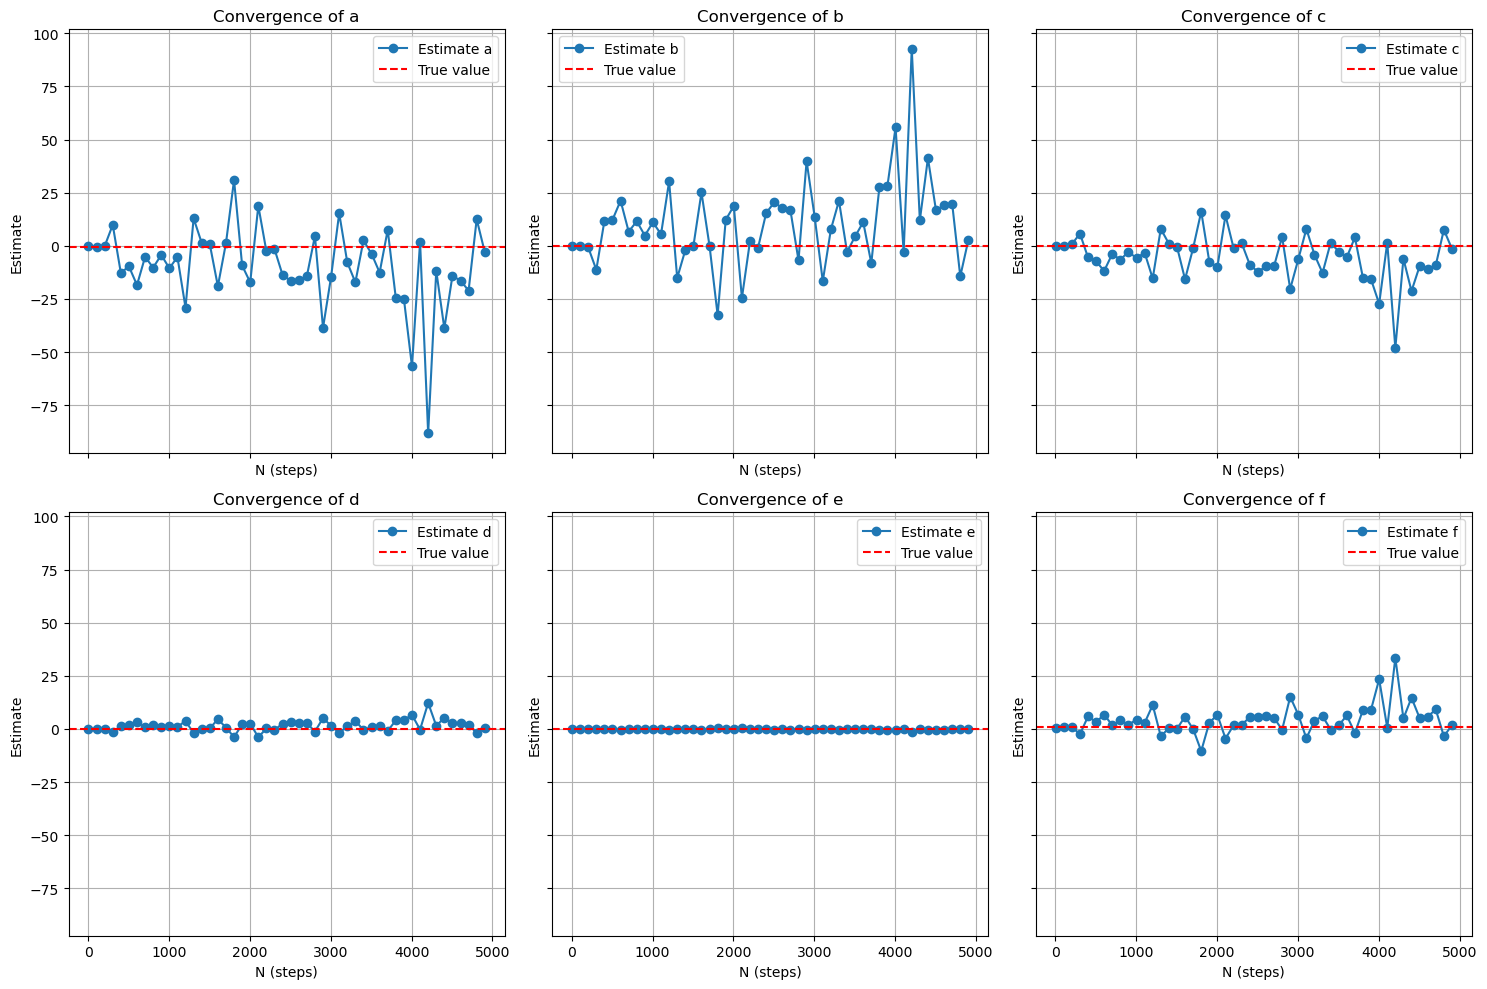

In [12]:
# Range of N (number of steps) for different simulations
N_values = range(5, 5000, 100)

# Store parameter estimates for each N
estimates = []
for N in N_values:
    # Simulate the data
    delta_t = T / N
    _, Xt = euler_maruyama_drift(T, N, x0, a_true, f_true, sigma_true)
    
    # Estimate derivatives
    dxdt = estimate_dx_dt(Xt, delta_t)
    
    # Create design matrix and solve for coefficients
    X = design_matrix(Xt[:-1])
    beta = minimize_ols(X, dxdt)
    estimates.append(beta)

# Convert estimates to numpy array for easier plotting
estimates = np.array(estimates)

# Ground truth values for comparison
true_values = [-a_true, 0, 0, 0, 0, f_true]

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.plot(N_values, estimates[:, i], marker="o", label=f"Estimate {['a', 'b', 'c', 'd', 'e', 'f'][i]}")
    ax.axhline(true_values[i], color="red", linestyle="--", label="True value")
    ax.set_title(f"Convergence of {['a', 'b', 'c', 'd', 'e', 'f'][i]}")
    ax.set_xlabel("N (steps)")
    ax.set_ylabel("Estimate")
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

We can see that, for very high polynomial coefficients $d,e$, the estimates are pretty close to 0. That said, $b,c$ do not seem to converge as expected, likewise $a,f$ do not converge to true drift values either. This can be attributed to $\sigma \; dW_t$ term in the true SDE, which also we can model using the residuals as follows:
$$ \hat{\sigma}_t = \frac{dx_t}{dt} - (-ax_t + f) $$

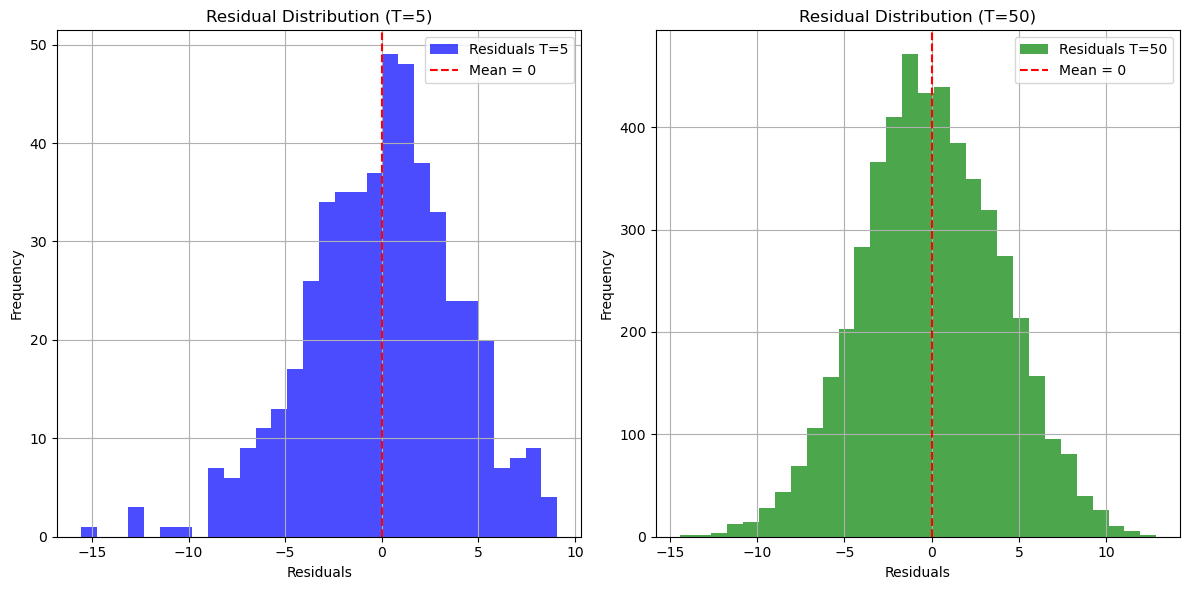

Estimated sigma for T=5: 3.8944932102131204
Estimated sigma for T=50: 3.970661107461299


In [13]:
# Function to compute residuals
def compute_residuals(dxdt, x, beta):
    drift = np.dot(design_matrix(x), beta)  # Predicted drift from Ansatz model
    return dxdt - drift

# Compute residuals for T = 5 and T = 50
residuals_short = compute_residuals(true_short_dxdt, true_short[:-1], beta_short)
residuals_long = compute_residuals(true_long_dxdt, true_long[:-1], beta_long)

# Plot residuals
plt.figure(figsize=(12, 6))

# Residuals for T = 5
plt.subplot(1, 2, 1)
plt.hist(residuals_short, bins=30, color='blue', alpha=0.7, label="Residuals T=5")
plt.axvline(0, color='red', linestyle='--', label="Mean = 0")
plt.title("Residual Distribution (T=5)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.legend()
plt.grid()

# Residuals for T = 50
plt.subplot(1, 2, 2)
plt.hist(residuals_long, bins=30, color='green', alpha=0.7, label="Residuals T=50")
plt.axvline(0, color='red', linestyle='--', label="Mean = 0")
plt.title("Residual Distribution (T=50)")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Noise estimation (standard deviation of residuals)
sigma_estimated_short = np.std(residuals_short)
sigma_estimated_long = np.std(residuals_long)

print(f"Estimated sigma for T=5: {sigma_estimated_short}")
print(f"Estimated sigma for T=50: {sigma_estimated_long}")

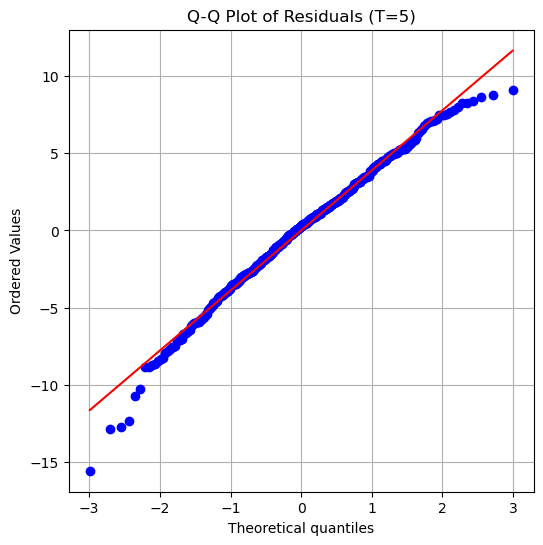

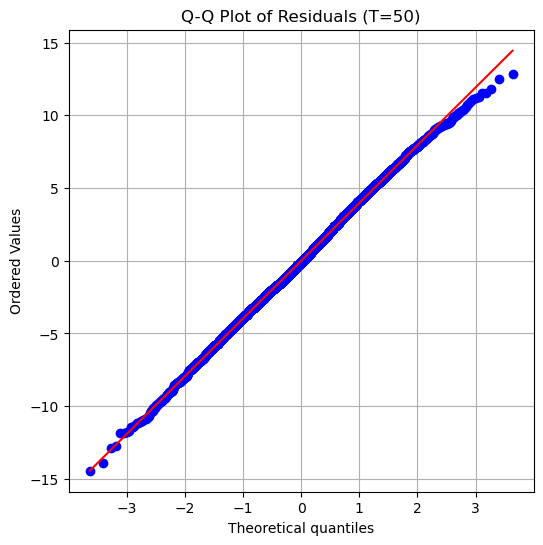

In [14]:
import scipy.stats as stats

# Q-Q Plot Function
def qq_plot(residuals, title):
    plt.figure(figsize=(6, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(title)
    plt.grid()
    plt.show()

# Perform Q-Q plots for residuals
qq_plot(residuals_short, "Q-Q Plot of Residuals (T=5)")
qq_plot(residuals_long, "Q-Q Plot of Residuals (T=50)")